# Advanced Lane Findig

In [1]:
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from collections import deque
%matplotlib inline

## Helper functions

In [2]:
def read_test_image(filename):  
    return mpimg.imread(os.path.join('test_images', filename))
                       
def save_output_image(image, filename):  
     mpimg.imsave(os.path.join('output_images', filename), image)

def show_before_and_after(before_image, after_image, before_title, after_title):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    f.tight_layout()
    
    if len(before_image.shape) == 3:
        ax1.imshow(before_image)
    else:
        ax1.imshow(before_image, cmap='gray')
    
    ax1.set_title(before_title, fontsize=20)
        
    if len(after_image.shape) == 3:
        ax2.imshow(after_image)
    else:
        ax2.imshow(after_image, cmap='gray')
    
    ax2.set_title(after_title, fontsize=20)
        
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Step 1: Camera Calibration

In [3]:
def camera_calibration(images, grid_size, image_size):
    objp = np.zeros((grid_size[0] * grid_size[1], 3), np.float32)
    objp[:, :2] = np.mgrid[0:grid_size[0], 0:grid_size[1]].T.reshape(-1, 2)

    objpoints = []  # 3d points in real world space
    imgpoints = []  # 2d points in image plane.

    for filename in images:
        image = mpimg.imread(filename)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, grid_size, None)

        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
        else:
            print("Unable to find appropriate number of corners on {0}".format(filename))

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_size, None, None)
    return mtx, dist

Unable to find appropriate number of corners on camera_cal\calibration1.jpg
Unable to find appropriate number of corners on camera_cal\calibration4.jpg
Unable to find appropriate number of corners on camera_cal\calibration5.jpg


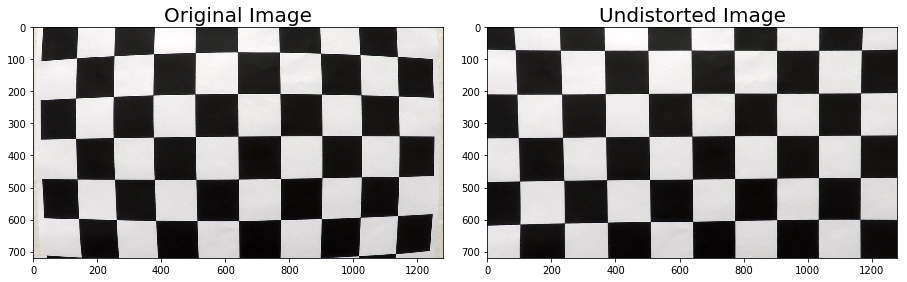

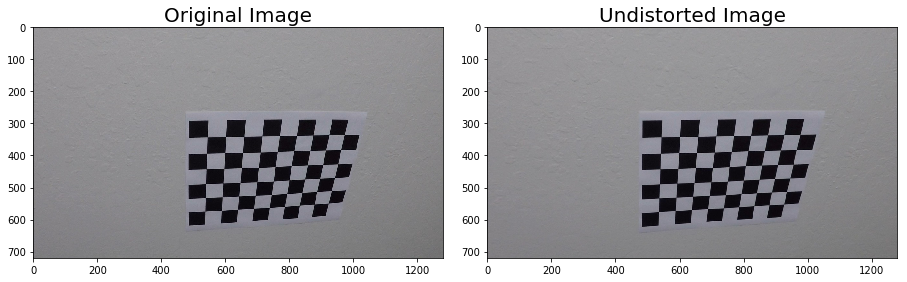

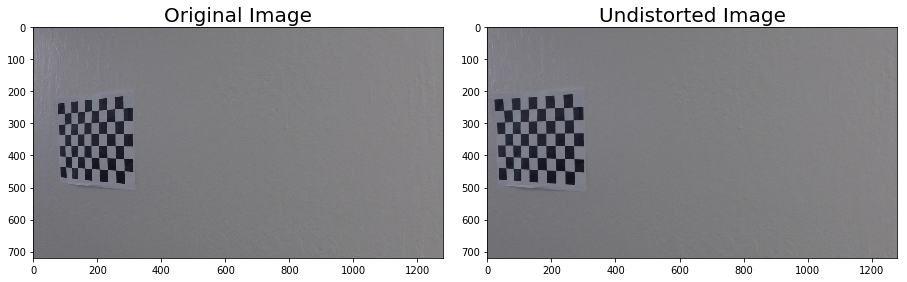

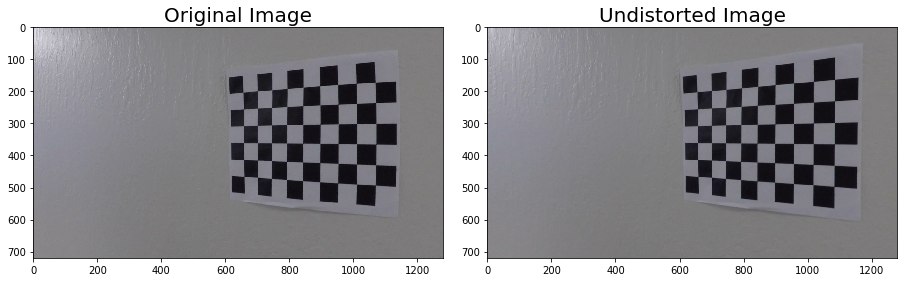

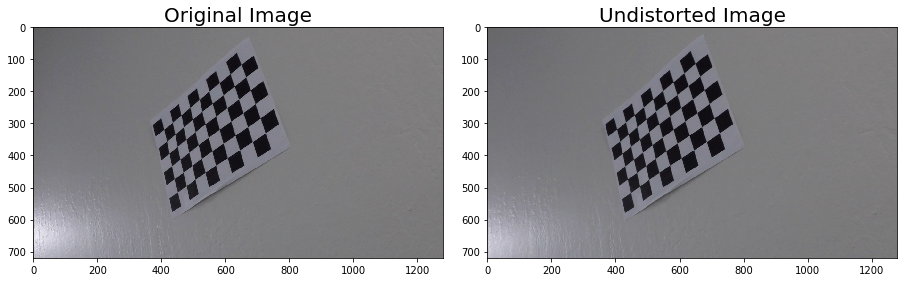

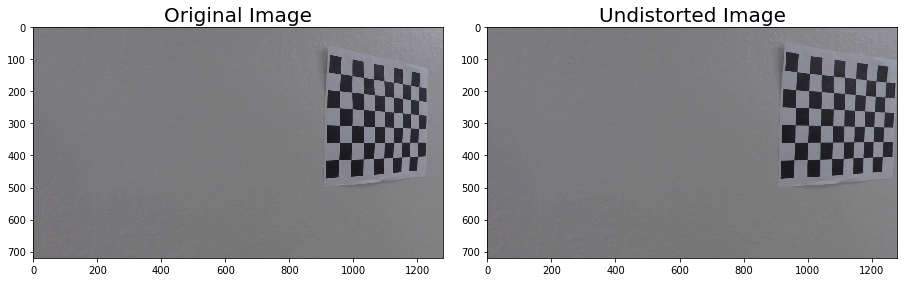

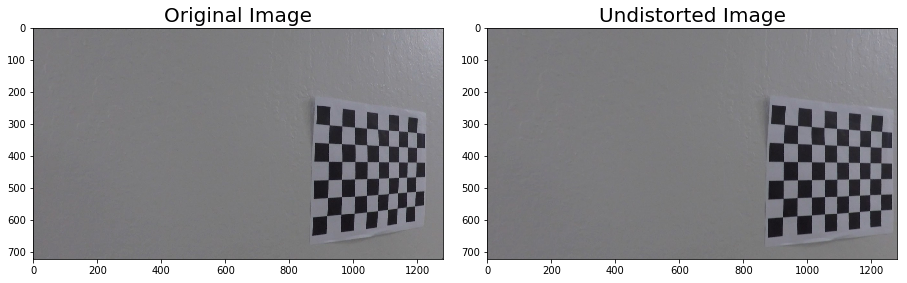

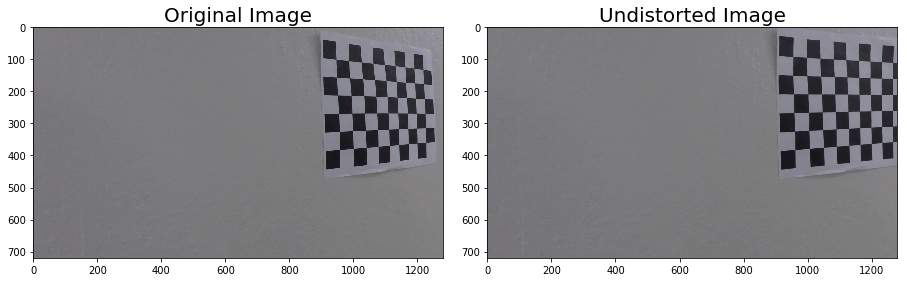

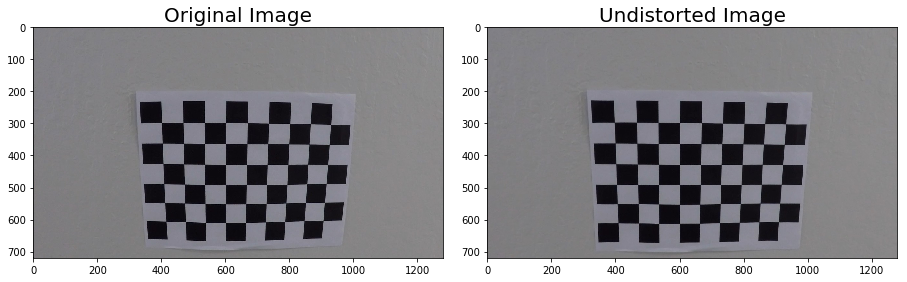

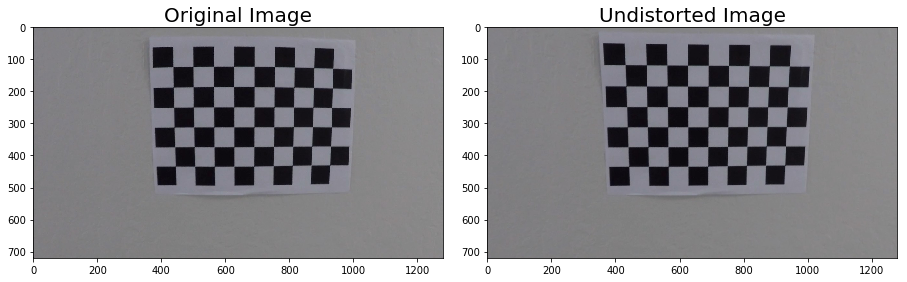

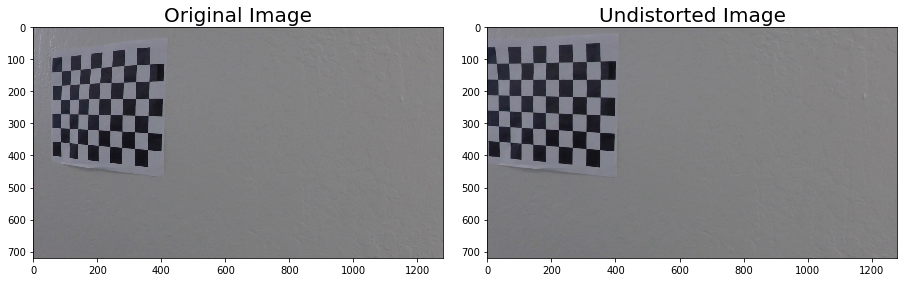

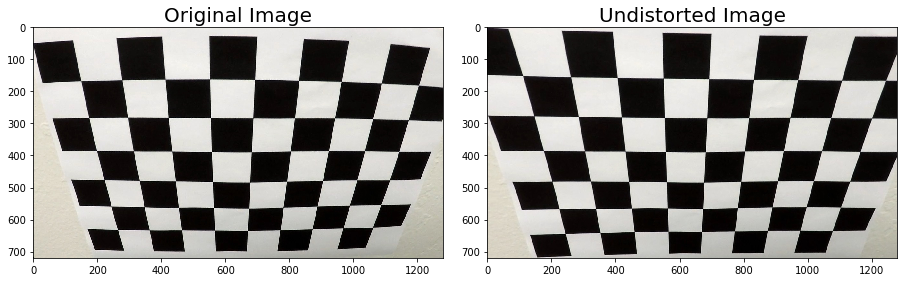

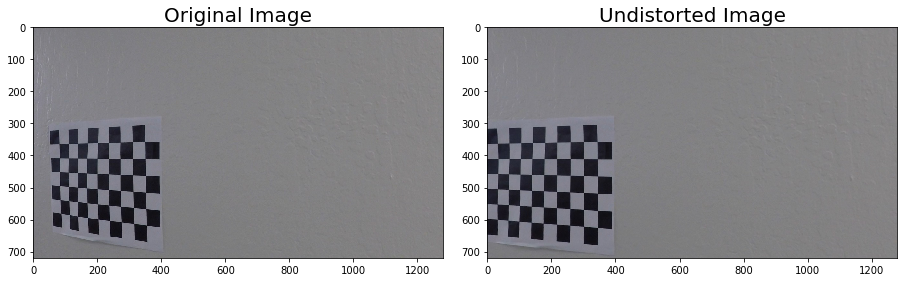

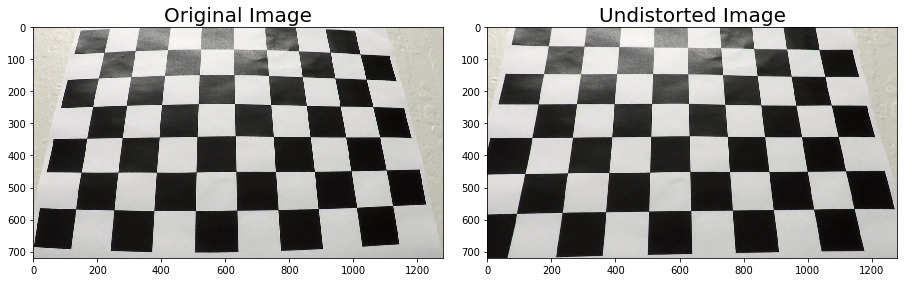

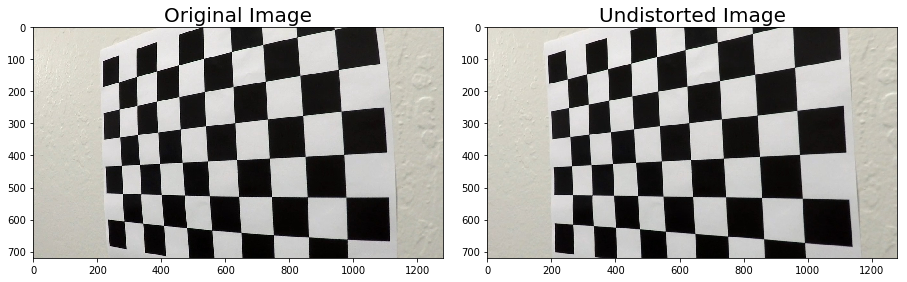

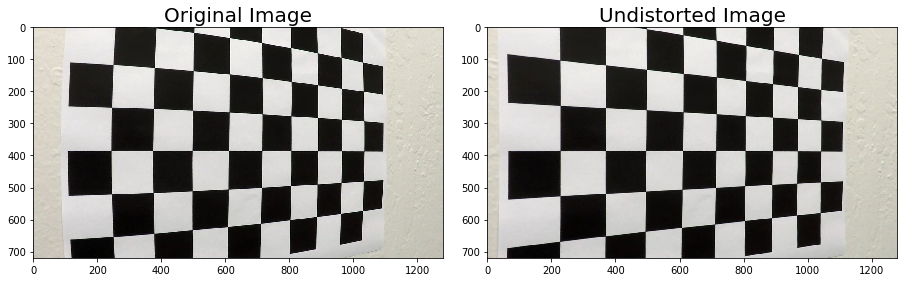

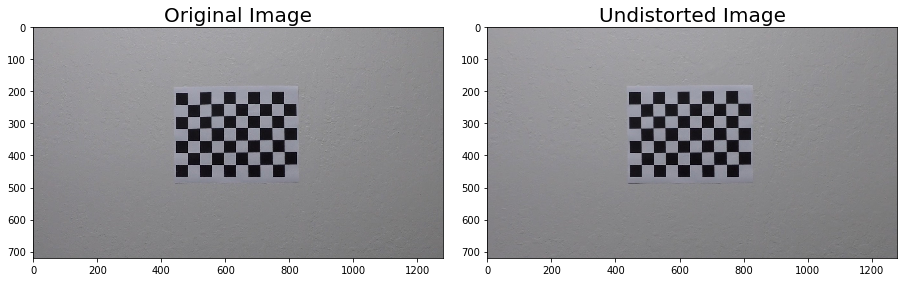

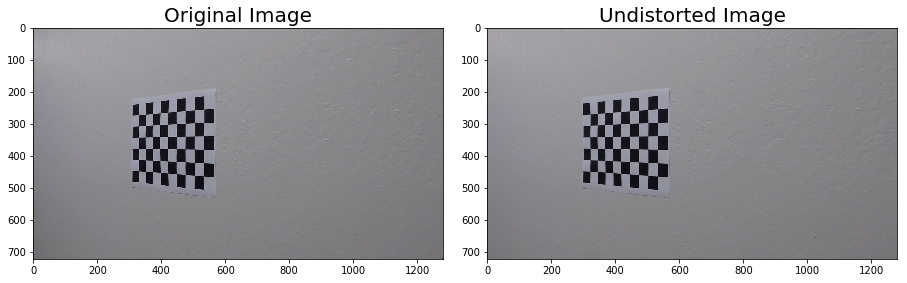

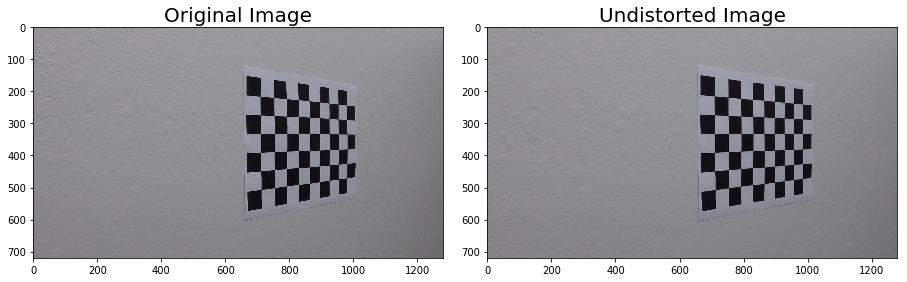

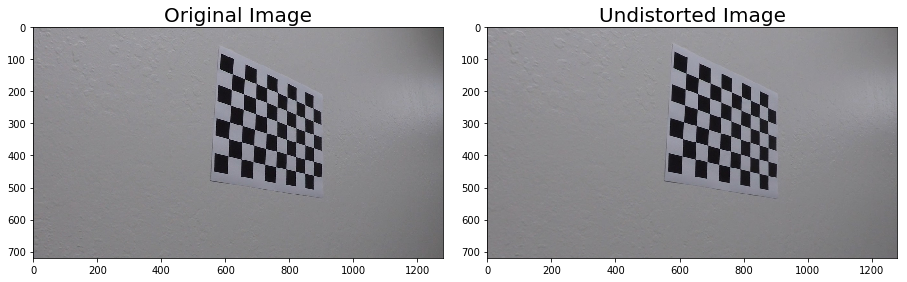

In [4]:
images = glob.glob('camera_cal/calibration*.jpg')
image = mpimg.imread(images[0]) # read first calibration image to obtain the camera's image size, needed for calibration

grid_size = (9, 6) # corner points of the chessboard calibration images 
mtx, dist = camera_calibration(images, grid_size, image.shape[1::-1])

for filename in images:
    original = mpimg.imread(filename)
    undist = cv2.undistort(original, mtx, dist, None, mtx)
    show_before_and_after(original, undist, before_title="Original Image", after_title = "Undistorted Image")


### Undistort Test Images

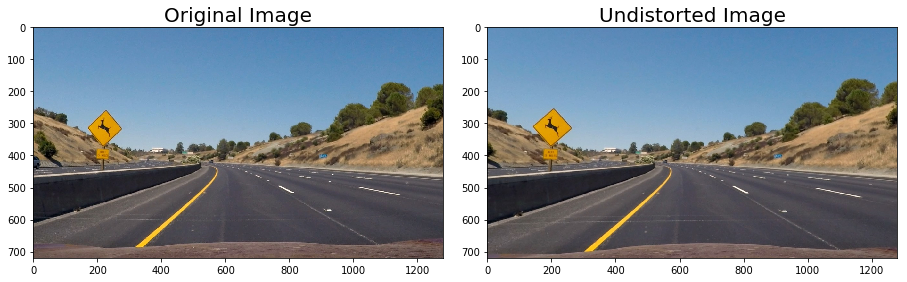

In [5]:
test_image = read_test_image('test2.jpg')
undist = cv2.undistort(test_image, mtx, dist, None, mtx)
show_before_and_after(test_image, undist, before_title="Original Image", after_title = "Undistorted Image")
mpimg.imsave('test1.jpg', undist)

In [6]:
def read_and_undistort(filename):
    image = read_test_image(filename)
    if image.shape[2] == 4:
        image = image[:,:,:3]
        
    image = cv2.undistort(image, mtx, dist, None, mtx)
    return image

def read_and_undistort_test_images():
    images = []
    for filepath in glob.glob('test_images/*.jpg'):
        image= mpimg.imread(filepath)
        if image.shape[2] == 4:
            image = image[:,:,:3]
        image = cv2.undistort(image, mtx, dist, None, mtx)
        images.append(image)        
    
    return images

## Transform Image for Line Detection

In [7]:
def abs_sobel_threshold(image, orient='x', kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    if orient == 'x':
        d = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        d = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    abs_d = np.absolute(d)
    scaled = np.uint8(255*abs_d/np.max(abs_d))
    
    binary_output = np.zeros_like(scaled)
    binary_output[(scaled >= thresh[0]) & (scaled <= thresh[1])] = 1
    return binary_output

def mag_threshold(image, kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel)

    magnitude = np.sqrt(sobelx **2 + sobely ** 2)
    
    scaled_sobel = np.uint8(255*magnitude/np.max(magnitude))

    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def dir_threshold(image, kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel)

    abs_x = np.absolute(sobelx)
    abs_y = np.absolute(sobely)

    dir = np.arctan2(abs_y, abs_x)
    
    binary_output = np.zeros_like(dir)
    binary_output[(dir >= thresh[0]) & (dir <= thresh[1])] = 1
    return binary_output

def hls_channel_threshold(image, channel="h", thresh=(0, 255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    if channel == 'h':
        channel_data = hls[:,:,0]
    elif channel == 'l':
        channel_data = hls[:,:,1]
    else:
        channel_data = hls[:,:,2]
    
    binary = np.zeros_like(channel_data)
    binary[(channel_data >= thresh[0]) & (channel_data <= thresh[1])] = 1
    return binary

def rgb_channel_threshold(image, channel="r", thresh=(0, 255)):
    if channel == 'r':
        channel_data = image[:,:,0]
    elif channel == 'g':
        channel_data = image[:,:,1]
    else:
        channel_data = image[:,:,2]
    
    binary = np.zeros_like(channel_data)
    binary[(channel_data >= thresh[0]) & (channel_data <= thresh[1])] = 1
    return binary

def hsv_channel_threshold(image, channel="h", thresh=(0, 255)):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    if channel == 'h':
        channel_data = hsv[:,:,0]
    elif channel == 's':
        channel_data = hsv[:,:,1]
    else:
        channel_data = hsv[:,:,2]
    
    binary = np.zeros_like(channel_data)
    binary[(channel_data >= thresh[0]) & (channel_data <= thresh[1])] = 1
    return binary

### HLS Saturation

In [10]:
from ipywidgets import widgets
from ipywidgets import interact

test_images = read_and_undistort_test_images()

def show(s_min, s_max):
    for image in test_images:
        color_binary = hls_channel_threshold(image, 's', thresh=(s_min, s_max))
        show_before_and_after(image, color_binary, before_title="Original", after_title="Sat Threshold")

interact(show, s_min=widgets.IntSlider(min=0,max=255,step=1,value=170, continuous_update=False, description="Min Color:"),
               s_max=widgets.IntSlider(min=0,max=255,step=1,value=255, continuous_update=False, description="Max Color:"))

interactive(children=(IntSlider(value=170, continuous_update=False, description='Min Color:', max=255), IntSli…

<function __main__.show(s_min, s_max)>

### HLS Lightness

In [11]:
def show(l_min, l_max):
    for image in test_images:
        color_binary = hls_channel_threshold(image, 'l', thresh=(l_min, l_max))
        show_before_and_after(image, color_binary, before_title="Original", after_title="L Threshold")

interact(show, l_min=widgets.IntSlider(min=0,max=255,step=1,value=170, continuous_update=False, description="Min Color:"),
               l_max=widgets.IntSlider(min=0,max=255,step=1,value=255, continuous_update=False, description="Max Color:"))

interactive(children=(IntSlider(value=170, continuous_update=False, description='Min Color:', max=255), IntSli…

<function __main__.show(l_min, l_max)>

In [12]:
def show(r_min, r_max):
    for image in test_images:
        color_binary = rgb_channel_threshold(image, 'r', thresh=(r_min, r_max))
        show_before_and_after(image, color_binary, before_title="Original", after_title="Red Thresholded")

interact(show, r_min=widgets.IntSlider(min=0,max=255,step=1,value=170, continuous_update=False, description="Min Color:"),
               r_max=widgets.IntSlider(min=0,max=255,step=1,value=255, continuous_update=False, description="Max Color:"))

interactive(children=(IntSlider(value=170, continuous_update=False, description='Min Color:', max=255), IntSli…

<function __main__.show(r_min, r_max)>

In [20]:
def mask_it(image, h_min, h_max, s_min, s_max, v_min, v_max):
    h_binary = hls_channel_threshold(image, 'h', thresh=(h_min, h_max))
    s_binary = hls_channel_threshold(image, 's', thresh=(s_min, s_max))
    v_binary = hls_channel_threshold(image, 'l', thresh=(v_min, v_max))
    
    combined = np.zeros_like(h_binary)
    combined[((h_binary == 1) & (s_binary == 1) & (v_binary == 1))] = 255
    return combined

def make_multichannel(image):
    return np.uint8(np.dstack([image, image, image]))

def show(h_min, h_max, s_min, s_max, v_min, v_max):
    for image in test_images:
        combined = mask_it(image, h_min, h_max, s_min, s_max, v_min, v_max)
        merged = cv2.addWeighted(image, 1.0, make_multichannel(combined), 0.7, 0)
        show_before_and_after(image, combined, before_title="Original", after_title="HSV Thresholded")

interact(show, h_min=widgets.IntSlider(min=0,max=255,step=1,value=170, continuous_update=False, description="Min H:"),
               h_max=widgets.IntSlider(min=0,max=178,step=1,value=178, continuous_update=False, description="Max H:"),
               s_min=widgets.IntSlider(min=0,max=255,step=1,value=170, continuous_update=False, description="Min S:"),
               s_max=widgets.IntSlider(min=0,max=255,step=1,value=255, continuous_update=False, description="Max S:"),
               v_min=widgets.IntSlider(min=0,max=255,step=1,value=170, continuous_update=False, description="Min V:"),
               v_max=widgets.IntSlider(min=0,max=255,step=1,value=255, continuous_update=False, description="Max V:"))

interactive(children=(IntSlider(value=170, continuous_update=False, description='Min H:', max=255), IntSlider(…

<function __main__.show(h_min, h_max, s_min, s_max, v_min, v_max)>

In [122]:
def mask_it(image, r_min, r_max, g_min, g_max, b_min, b_max):
    r_binary = rgb_channel_threshold(image, 'r', thresh=(r_min, r_max))
    g_binary = rgb_channel_threshold(image, 'g', thresh=(g_min, g_max))
    b_binary = rgb_channel_threshold(image, 'b', thresh=(b_min, b_max))
    
    combined = np.zeros_like(r_binary)
    combined[((r_binary == 1) & (g_binary == 1) & (b_binary == 1))] = 255
    return combined

def show(r_min, r_max, g_min, g_max, b_min, b_max):
    for image in test_images:
        combined = mask_it(image, r_min, r_max, g_min, g_max, b_min, b_max)
        show_before_and_after(image, combined, before_title="Original", after_title="Thresholded")

interact(show, r_min=widgets.IntSlider(min=0,max=255,step=1,value=170, continuous_update=False, description="Min R:"),
               r_max=widgets.IntSlider(min=0,max=255,step=1,value=178, continuous_update=False, description="Max R:"),
               g_min=widgets.IntSlider(min=0,max=255,step=1,value=170, continuous_update=False, description="Min G:"),
               g_max=widgets.IntSlider(min=0,max=255,step=1,value=255, continuous_update=False, description="Max G:"),
               b_min=widgets.IntSlider(min=0,max=255,step=1,value=170, continuous_update=False, description="Min B:"),
               b_max=widgets.IntSlider(min=0,max=255,step=1,value=255, continuous_update=False, description="Max B:"))

interactive(children=(IntSlider(value=170, continuous_update=False, description='Min R:', max=255), IntSlider(…

<function __main__.draw(r_min, r_max, g_min, g_max, b_min, b_max)>

In [17]:
ksize = 3

def show(min, max):
    for image in test_images:
        mag_binary = mag_threshold(image, kernel=ksize, thresh=(min, max))
        show_before_and_after(image, mag_binary, before_title="Original", after_title="Sobel Magnitude")


interact(show, min=widgets.IntSlider(min=0,max=255,step=1,value=30, continuous_update=False, description="Min:"),
               max=widgets.IntSlider(min=0,max=255,step=1,value=200, continuous_update=False, description="Max:"))

interactive(children=(IntSlider(value=30, continuous_update=False, description='Min:', max=255), IntSlider(val…

<function __main__.show(min, max)>